In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt



# Fetch the data
ticker_symbol = "MQG.AX"
westpac = yf.Ticker(ticker_symbol)
data = westpac.history(period="10y", interval="1wk")


: 

In [14]:
!pip install scikit-optimize

  Obtaining dependency information for scikit-optimize from https://files.pythonhosted.org/packages/90/0e/15deb91b3db0003843e34e72fa865e1d92013781d986fdc65483c99a9f69/scikit_optimize-0.10.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for pyaml>=16.9 from https://files.pythonhosted.org/packages/70/d9/6fdc01cee01fe56fddfd46892d9846ebb53a5f8eb78056955c516eef42c5/pyaml-24.4.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/107.7 kB ? eta -:--:--
   ---------------------------------------- 107.7/107.7 kB 6.1 MB/s eta 0:00:00


In [ ]:
print(data)

: 

In [2]:
# define target value (closing price of the next day)
data['Target'] = data['Close'].shift(-1) # -1 used to used next day's price as target
print(data)

                                 Open        High         Low       Close  \
Date                                                                        
2014-05-26 00:00:00+10:00   39.357972   39.416560   39.025976   39.078053   
2014-06-02 00:00:00+10:00   39.078051   39.442598   38.414056   39.123619   
2014-06-09 00:00:00+10:00   39.123618   39.572793   38.863229   39.045502   
2014-06-16 00:00:00+10:00   38.993419   39.833175   38.778596   39.384003   
2014-06-23 00:00:00+10:00   39.423063   39.813647   38.804636   39.357964   
...                               ...         ...         ...         ...   
2024-04-29 00:00:00+10:00  184.578419  184.862636  179.707422  180.168060   
2024-05-06 00:00:00+10:00  178.237300  189.733631  177.247425  189.420013   
2024-05-13 00:00:00+10:00  186.303348  189.959056  183.010280  187.058014   
2024-05-20 00:00:00+10:00  191.320007  196.179993  190.610001  192.210007   
2024-05-27 00:00:00+10:00  194.080002  194.449997  188.389999  189.479996   

In [3]:
# add indicators

# SMA-10
data['SMA_10'] = data['Close'].rolling(window=10).mean().shift(1)
# SMA 25
data['SMA_25'] = data['Close'].rolling(window=25).mean().shift(1)

# Momentum (Close price difference shifted by 1 to use previous day's data)
data['Momentum'] = data['Close'].diff().shift(1)

# Stochastic %K and %D using data up to the previous day
low_min = data['Low'].rolling(window=14).min().shift(1)
high_max = data['High'].rolling(window=14).max().shift(1)
data['Stochastic_%K'] = ((data['Close'].shift(1) - low_min) / (high_max - low_min)) * 100
data['Stochastic_%D'] = data['Stochastic_%K'].rolling(window=3).mean()

# RSI calculated from previous days
delta = data['Close'].diff(1).shift(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# MACD calculation shifted to include only past data
exp1 = data['Close'].ewm(span=12, adjust=False).mean().shift(1)
exp2 = data['Close'].ewm(span=26, adjust=False).mean().shift(1)
macd = exp1 - exp2
signal = macd.ewm(span=9, adjust=False).mean()
data['MACD'] = macd
data['MACD_Signal'] = signal


# list of columns
columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
           'Target', 'SMA_10', 'SMA_25', 'Momentum', 'Stochastic_%K', 'Stochastic_%D', 'RSI',
           'MACD', 'MACD_Signal']

# reorder columns to put 'Target' in the end
columns.remove('Target')
columns.append('Target')
data= data[columns]

print(data.head(20))

                                Open       High        Low      Close  \
Date                                                                    
2014-05-26 00:00:00+10:00  39.357972  39.416560  39.025976  39.078053   
2014-06-02 00:00:00+10:00  39.078051  39.442598  38.414056  39.123619   
2014-06-09 00:00:00+10:00  39.123618  39.572793  38.863229  39.045502   
2014-06-16 00:00:00+10:00  38.993419  39.833175  38.778596  39.384003   
2014-06-23 00:00:00+10:00  39.423063  39.813647  38.804636  39.357964   
2014-06-30 00:00:00+10:00  39.442591  39.631375  38.296876  39.344944   
2014-07-07 00:00:00+10:00  39.397032  39.449108  38.101590  38.576801   
2014-07-14 00:00:00+10:00  38.648399  39.165925  38.283854  39.058514   
2014-07-21 00:00:00+10:00  39.227775  39.885261  38.003943  38.160175   
2014-07-28 00:00:00+10:00  37.567791  38.101591  37.170696  37.567791   
2014-08-04 00:00:00+10:00  37.463628  37.750058  35.998933  36.226776   
2014-08-11 00:00:00+10:00  36.584810  37.378998  36

In [4]:
# delete rows with null/nan values
data = data.dropna()
print(len(data))
print(data)

497
                                 Open        High         Low       Close  \
Date                                                                        
2014-11-17 00:00:00+11:00   40.096588   40.143134   38.633694   38.866428   
2014-11-24 00:00:00+11:00   39.165651   39.764106   38.646987   38.853123   
2014-12-01 00:00:00+11:00   39.491480   40.495558   38.214774   40.163082   
2014-12-08 00:00:00+11:00   40.475607   40.828033   38.500703   38.766682   
2014-12-15 00:00:00+11:00   37.988690   38.447506   36.964664   38.447506   
...                               ...         ...         ...         ...   
2024-04-22 00:00:00+10:00  181.794984  187.616644  180.726686  182.696655   
2024-04-29 00:00:00+10:00  184.578419  184.862636  179.707422  180.168060   
2024-05-06 00:00:00+10:00  178.237300  189.733631  177.247425  189.420013   
2024-05-13 00:00:00+10:00  186.303348  189.959056  183.010280  187.058014   
2024-05-20 00:00:00+10:00  191.320007  196.179993  190.610001  192.21000

In [5]:
contains_nan = data.isna().any().any()
print("Contains NaN:", contains_nan)

num_rows_with_nan = data.isna().any(axis=1).sum()
print("Number of rows with NaN:", num_rows_with_nan)

Contains NaN: False
Number of rows with NaN: 0


In [8]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Real

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into features and target
features = scaled_data[:, :-1]
target = scaled_data[:, -1]

split_idx = int(len(features) * 0.7)
X_train = features[:split_idx]
X_test = features[split_idx:]


# Split the target into training and testing sets
y_train = target[:split_idx]
y_test = target[split_idx:]

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


search_spaces = {
    'C': Real(0.1, 1000, prior='log-uniform'),
    'epsilon': Real(0.1, 2, prior='log-uniform')
}

# Perform Bayesian Optimization
svm_regressor = SVR(kernel='linear')

bayes_search = BayesSearchCV(estimator=svm_regressor, search_spaces=search_spaces, n_iter=50, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
bayes_search.fit(X_train, y_train)

model = bayes_search.best_estimator_

# Make predictions
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.017153034781327032


In [9]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score


r2 = r2_score(y_test, predictions)
print("R^2 Score:", r2)

explained_variance = explained_variance_score(y_test, predictions)
print("Explained Variance Score:", explained_variance)


R^2 Score: -1.664616928824635
Explained Variance Score: 0.7559952165685087


In [10]:
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError

y_pred = predictions

# Calculating Mean Squared Error (MSE)
mse = MeanSquaredError()
mse.update_state(y_test, y_pred)
mse_result = mse.result().numpy()
print("Mean Squared Error (MSE):", mse_result)

# Calculating Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse_result)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculating Mean Absolute Error (MAE)
mae = MeanAbsoluteError()
mae.update_state(y_test, y_pred)
mae_result = mae.result().numpy()
print("Mean Absolute Error (MAE):", mae_result)

# Optionally, calculating R^2 (Coefficient of Determination)
# This is not built into Keras, so we use sklearn's functionality
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R^2 (Coefficient of Determination):", r2)

Mean Squared Error (MSE): 0.017153034
Root Mean Squared Error (RMSE): 0.1309696
Mean Absolute Error (MAE): 0.12509207
R^2 (Coefficient of Determination): -1.664616928824635


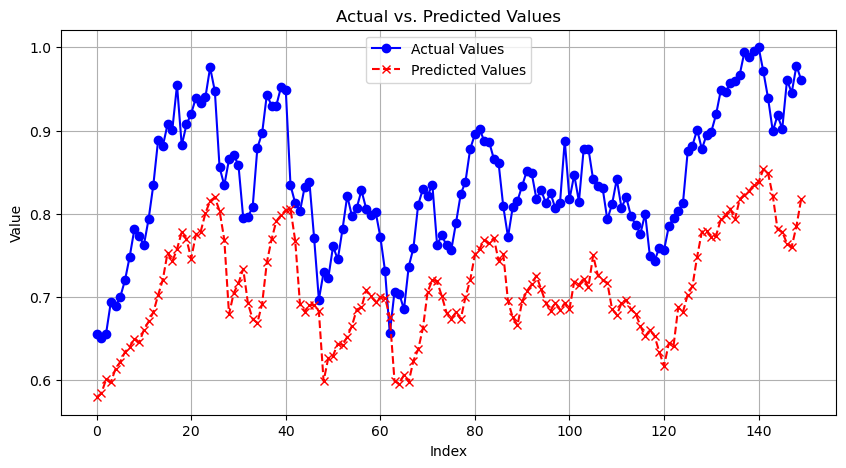

In [11]:
import matplotlib.pyplot as plt

import numpy as np

# If y_test and predictions are not already numpy arrays or if index needs reset
y_test = np.array(y_test)
predictions = np.array(predictions)

# Plot using explicit indices for clarity
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label='Actual Values', color='blue', marker='o')
plt.plot(range(len(predictions)), predictions, label='Predicted Values', color='red', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
